https://arxiv.org/abs/1008.4686

In [1]:
import numpy as np

import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

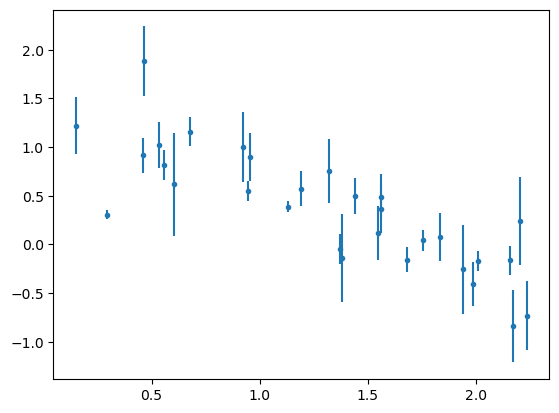

In [2]:
x, y, y_err = np.loadtxt("data/linear_fits/data_1.txt", unpack=True)

plt.errorbar(x, y, y_err, fmt=".")

In [3]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(y_err**2)
C_inv = np.linalg.inv(C)

ACA_inv = np.linalg.inv(A.T @ C_inv @ A)

b_ls, m_ls = ACA_inv @ A.T @ C_inv @ y
b_m_covariance = ACA_inv

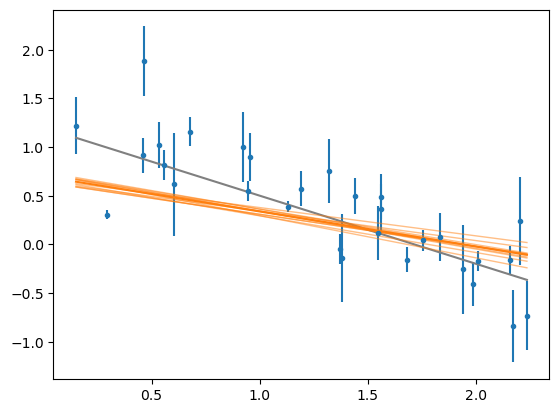

In [4]:
plt.errorbar(x, y, y_err, fmt=".")
m_true, b_true = -0.7, 1.2
plt.plot(x, m_true*x + b_true, c="grey")

plt.plot(x, m_ls*x + b_ls, c="C1")

b_ls_samples, m_ls_samples = np.array([b_ls, m_ls])[:, None] + np.linalg.cholesky(b_m_covariance) @ np.random.normal(size=(2, 10))

_ = plt.plot(x, (m_ls_samples[:,None]*x + b_ls_samples[:,None]).T, lw=1, alpha=0.5, c="C1")


In [5]:
def model(theta, x):
    m, b = theta
    return m*x + b 

def log_likelihood(data, theta, x, y_err):
    m, b, f = theta
    prediction = model((m, b), x)

    sigma_y = y_err + f*prediction**2

    log_like = -0.5 * np.sum((data - prediction)**2/sigma_y**2 + np.log(2*np.pi*sigma_y**2))
    return log_like

def log_prior(theta):
    m, b, f = theta

    return 0

def log_posterior(theta, data, x, y_err):
    return log_likelihood(data, theta, x, y_err) + log_prior(theta)

In [6]:
import scipy.optimize

def negative_log_posterior(theta, data, x, sigma_y):
    return -log_posterior(theta, data, x, sigma_y)

MAP_result = scipy.optimize.minimize(
    fun=negative_log_posterior,
    x0=(1, 0, 0.5),
    args=(y, x, y_err)
)
m_MAP, b_MAP, f_MAP = MAP_result.x
MAP_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.963804305721817
        x: [-7.368e-01  1.291e+00  2.926e-01]
      nit: 21
      jac: [ 2.682e-06  2.265e-06  2.861e-06]
 hess_inv: [[ 8.917e-03 -1.381e-02  4.010e-03]
            [-1.381e-02  2.314e-02 -6.780e-03]
            [ 4.010e-03 -6.780e-03  1.166e-02]]
     nfev: 144
     njev: 36

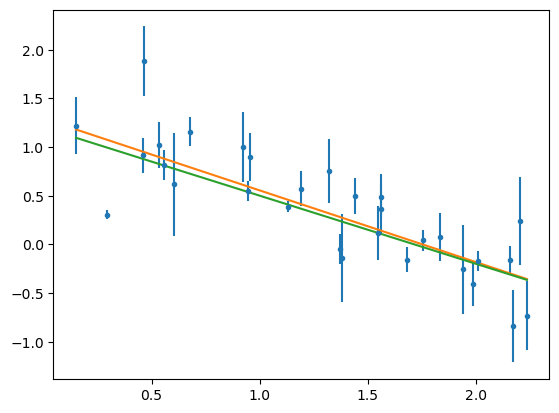

In [7]:
plt.errorbar(x, y, y_err, fmt=".")
plt.plot(x, model((m_MAP, b_MAP), x))
plt.plot(x, model((m_true, b_true), x))

In [8]:
import emcee

n_param = 3
n_walker = 10
n_step = 5000

theta_init = np.array([0.5, 0.5, 0.5]) + 0.1*np.random.normal(size=(n_walker, n_param))

sampler = emcee.EnsembleSampler(nwalkers=n_walker, ndim=n_param, log_prob_fn=log_posterior, args=(y, x, y_err))
state = sampler.run_mcmc(theta_init, nsteps=n_step)
print("Auto-correlation time:")
for name, value in zip(["m", "b", "f"], sampler.get_autocorr_time()):
    print(f"{name} = {value:.1f}")

Auto-correlation time:
m = 47.8
b = 47.0
f = 42.8


In [9]:
chain = sampler.get_chain(discard=200, thin=20, flat=True)

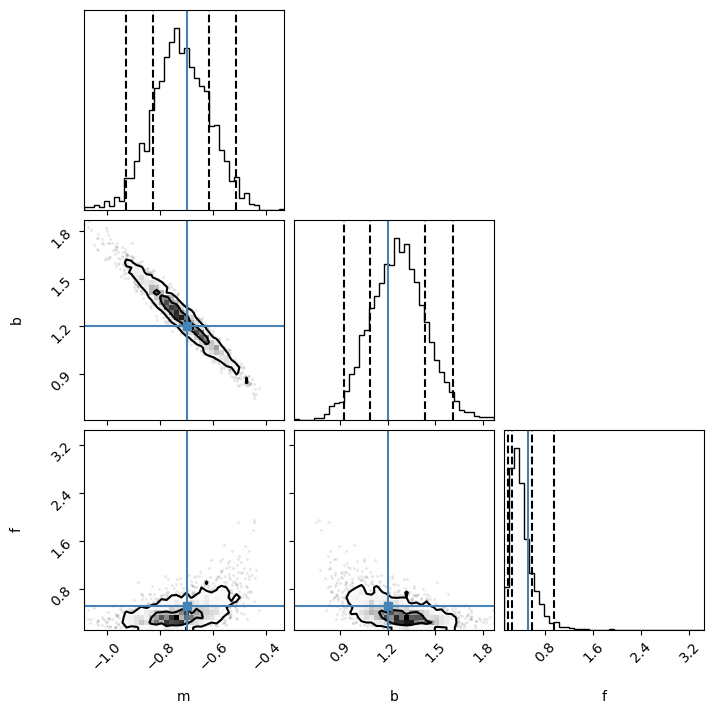

In [10]:
import corner

f_true = 0.51

_ = corner.corner(
    chain,
    bins=40,
    labels=["m", "b", "f"],
    truths=[m_true, b_true, f_true],
    # show_titles=True,
    levels=1-np.exp(-0.5*np.array([1, 2])**2), quantiles=[0.025, 0.16, 0.84, 0.975]
)

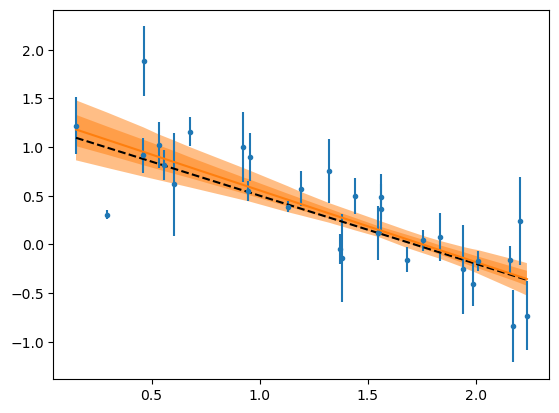

In [11]:
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
model_predictive = np.array([model(sample[:2], x) for sample in chain_samples])

model_quantiles = np.quantile(model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0)

plt.errorbar(x, y, y_err, fmt=".")
plt.plot(x, model((m_true, b_true), x), c="k", ls="--")

plt.plot(x, model((m_MAP, b_MAP), x), c="C1")
plt.fill_between(x, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1")
plt.fill_between(x, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1")


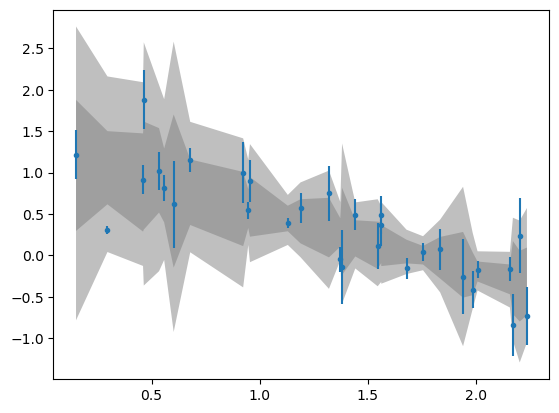

In [12]:

posterior_predictive = model_predictive + (y_err + chain_samples[:,2,None]*model_predictive**2)*np.random.normal(size=(200,30))
posterior_predictive_quantiles = np.quantile(posterior_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0)

plt.errorbar(x, y, y_err, fmt=".")
plt.fill_between(x, posterior_predictive_quantiles[0], posterior_predictive_quantiles[-1], facecolor="grey", alpha=0.5)
plt.fill_between(x, posterior_predictive_quantiles[1], posterior_predictive_quantiles[-2], facecolor="grey", alpha=0.5)

# plt.plot(x, predictions[:10].T, c="C3", lw=1, alpha=0.5)


In [13]:
import dynesty

def log_like_wrapper(theta, y, x, y_err):
    return log_likelihood(y, theta, x, y_err)

def prior_transform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 5. * (2. * u - 1.)

# "Static" nested sampling.
sampler = dynesty.NestedSampler(
    loglikelihood=log_like_wrapper,
    prior_transform=prior_transform,
    ndim=3,
    nlive=50,
    logl_args=(y, x, y_err),
)
sampler.run_nested(print_progress=True)
sresults = sampler.results
sresults.summary()

728it [00:02, 285.50it/s, +50 | bound: 69 | nc: 1 | ncall: 7092 | eff(%): 11.048 | loglstar:   -inf < -5.977 <    inf | logz: -17.525 +/-  0.442 | dlogz:  0.001 >  0.059]

Summary
nlive: 50
niter: 728
ncall: 7042
eff(%): 11.048
logz: -17.525 +/-  0.479


In [14]:
def model_quadratic(a, m, b, x):
    return a*x**2 + m*x + b

def log_likelihood_quadratic(theta, data, x, y_err):
    a, m, b, f = theta
    prediction = model_quadratic(a, m, b, x)

    sigma_y = y_err + f*prediction**2

    log_like = -0.5 * np.sum((data - prediction)**2/sigma_y**2 + np.log(2*np.pi*sigma_y**2))
    return log_like


def prior_transform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 5. * (2. * u - 1.)

# "Static" nested sampling.
sampler = dynesty.NestedSampler(
    loglikelihood=log_likelihood_quadratic,
    prior_transform=prior_transform,
    ndim=4,
    nlive=50,
    logl_args=(y, x, y_err)
)
sampler.run_nested(print_progress=True)
sresults_quadratic = sampler.results
sresults_quadratic.summary()

854it [00:04, 210.97it/s, +50 | bound: 144 | nc: 1 | ncall: 12648 | eff(%):  7.176 | loglstar:   -inf < -6.026 <    inf | logz: -20.089 +/-  0.487 | dlogz:  0.001 >  0.059]

Summary
nlive: 50
niter: 854
ncall: 12598
eff(%):  7.176
logz: -20.089 +/-  0.525


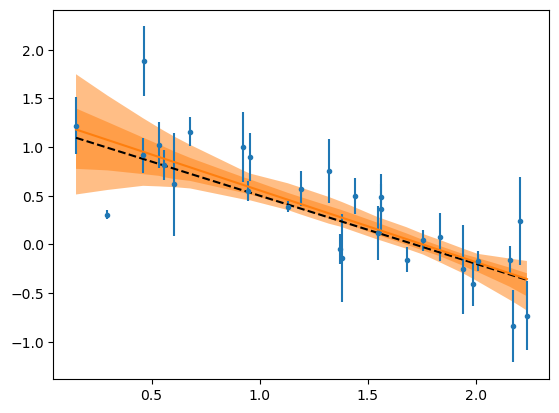

In [15]:
chain = sresults_quadratic.samples_equal()
chain_samples = chain[np.random.choice(chain.shape[0], size=200)]
model_predictive = np.array([model_quadratic(*sample[:-1], x) for sample in chain_samples])

model_quantiles = np.quantile(model_predictive, q=[0.025, 0.16, 0.84, 0.975], axis=0)

plt.errorbar(x, y, y_err, fmt=".")
plt.plot(x, model((m_true, b_true), x), c="k", ls="--")

plt.plot(x, model((m_MAP, b_MAP), x), c="C1")
plt.fill_between(x, model_quantiles[0], model_quantiles[-1], alpha=0.5, facecolor="C1")
plt.fill_between(x, model_quantiles[1], model_quantiles[-2], alpha=0.5, facecolor="C1")


array([0.5, 1. , 1.5, 2. ])

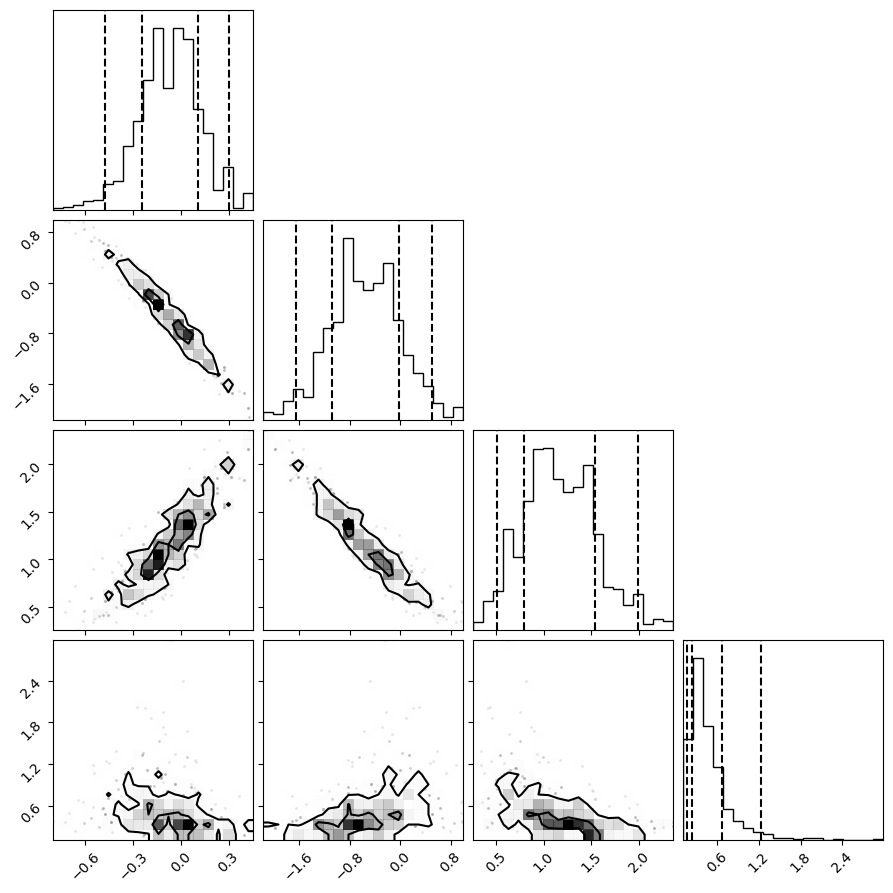

In [16]:
_ = corner.corner(
    sresults_quadratic.samples_equal(),
    levels=1-np.exp(-0.5*np.array([1, 2])**2), quantiles=[0.025, 0.16, 0.84, 0.975]
)
np.arange(0.5, 2.1, 0.5)

## JAX

In [17]:
import jax
import jax.numpy as jnp

import tensorflow_probability.substrates.jax as tfp

In [18]:
def model(theta, x):
    m, b = theta
    return m*x + b 

def log_likelihood(data, theta, x, y_err):
    m, b, f = theta
    prediction = model((m, b), x)

    sigma_y = y_err + f*prediction**2

    log_like = -0.5 * jnp.sum((data - prediction)**2/sigma_y**2 + jnp.log(2*jnp.pi*sigma_y**2))
    return log_like

def log_prior(theta):
    m, b, f = theta

    return 0

def log_posterior(theta, data, x, y_err):
    return log_likelihood(data, theta, x, y_err) + log_prior(theta)

def log_prob_wrapper(theta):
    return log_posterior(theta, data=y, x=x, y_err=y_err)

# Initialize the HMC transition kernel.
num_results = 2000
num_burnin_steps = 1000
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=jax.jit(jax.vmap(log_prob_wrapper)),
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8)
)

# Run the chain (with burn-in).
def run_chain():
    # Run the chain (with burn-in).
    samples, info = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=jnp.array(theta_init)[:4],
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: (pkr.inner_results.target_log_prob, pkr.inner_results.is_accepted),
        seed=jax.random.PRNGKey(42)
    )

    log_prob, is_accepted = info
    print(f"Acceptance rate: {is_accepted.sum()/is_accepted.size}")
    return samples, log_prob

samples, log_prob = run_chain()


Acceptance rate: 0.9509999752044678


In [19]:
import arviz as az

nuts_data = az.from_dict(
    posterior=dict(
        m=samples.swapaxes(0, 1)[..., 0],
        b=samples.swapaxes(0, 1)[..., 1],
        f=samples.swapaxes(0, 1)[..., 2],
    ),
)
az.summary(nuts_data)

/opt/conda/lib/python3.10/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,-0.724,0.106,-0.925,-0.520,0.003,0.002,1752.0,1834.0,1.0
b,1.268,0.175,0.948,1.615,0.004,0.003,1662.0,1701.0,1.0
f,0.421,0.217,0.151,0.781,0.007,0.006,1544.0,939.0,1.0


/opt/conda/lib/python3.10/site-packages/arviz/utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'f'}>, <Axes: title={'center': 'f'}>]],
      dtype=object)

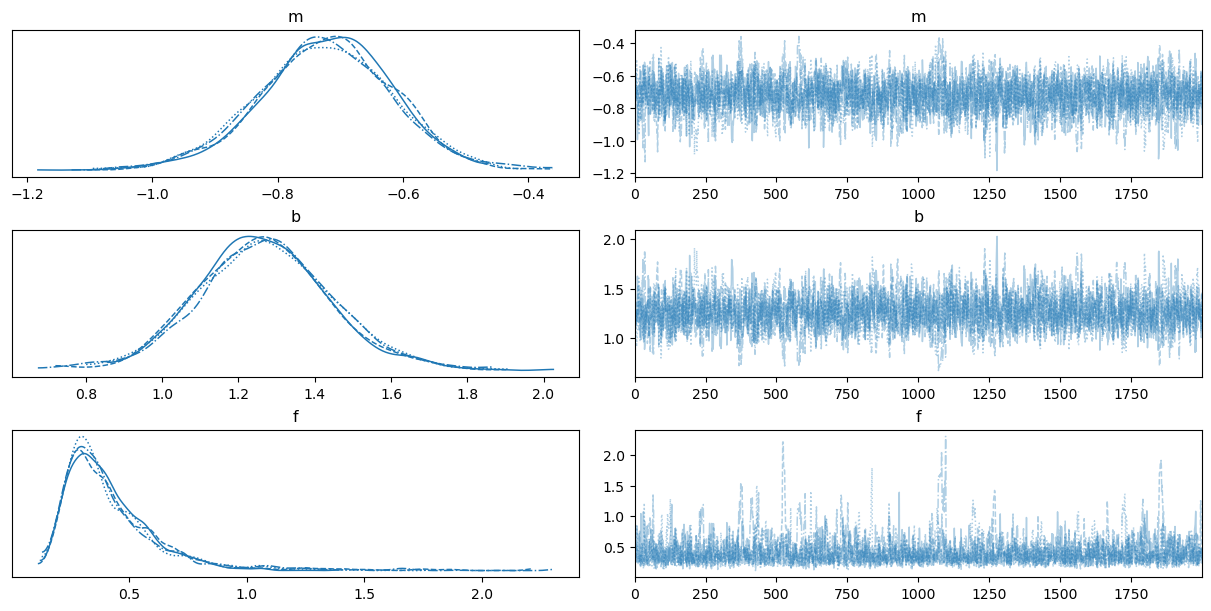

In [20]:
az.plot_trace(nuts_data)